### Let’s imagine you work on the product team at a medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

#### Dtaset source : https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv

### 1. Experiment design

#### Considering that we are not certain regarding the direction of the shift in coversion rate we will use a two tailed test 

Hₒ: p = pₒ
Hₐ: p ≠ pₒ

where p and pₒ stand for the conversion rate of the new and old design, respectively

Experiment parameters:

Confidence Interval - 95%
α = 0.05
power - 80%
MDE(Effect size) - 2%(Conversion rate)

For our test we’ll need two groups:
- A control group - They'll be shown the old design
- A treatment (or experimental) group - They'll be shown the new design

### 2. Power analysis and sample size setting

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.
On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

In [2]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

In [3]:
# Calculating effect size 

effect_size = sms.proportion_effectsize(0.13,0.15)

In [4]:
effect_size

-0.0576728617308947

In [5]:
sample_size = sms.NormalIndPower().solve_power(effect_size, power= 0.8, alpha = 0.05, ratio=1)

In [6]:
sample_size

4719.4740575998185

In [8]:
sample_size = ceil(sample_size)

In [11]:
print("The required sample same for the test is: ",sample_size)

The required sample same for the test is:  4720


### 3. Data upload and preperation

In [14]:
df = pd.read_csv('C:/Users/hmenon/Downloads/ab_data/ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
df.shape

(294478, 5)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [18]:
# Check to see if we have any missing data in the dataset
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [19]:
# Validate if the test executed as expected i.e Control received th eold page and treatment received the new page

pd.crosstab(df['group'],df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [23]:
# Before we get into the analysis let us ensure each user has one session that we are considering. 
# For that lets validate and identify users who have multiple entries in the dataset and understand how to handle these users

session_count = df.groupby('user_id').count()

In [29]:
print("Total unique users in the dtaset:",len(df['user_id'].unique()))

Total unique users in the dtaset: 290584


In [36]:
session_count = session_count[session_count['timestamp']>1]

In [31]:
# There are around 3894 users with multiple sessions out of 290k users which is quite negligible.
# If this population was sizeable we would want to dedup it to the first session per user
# We will go ahead and deletethese users since they are negligible

#If we were to obtain the first session per user use the code below
#df['timestamp'] = pd.to_datetime(df['timestamp'])
#df['rank_session_by_user'] = df.groupby('user_id')['timestamp'].rank(method='first')

In [37]:
users_to_drop = session_count.index

In [39]:
df = df[~df['user_id'].isin(users_to_drop)]

In [40]:
df.shape

(286690, 6)

#### Updated Dataset now has 286690 users

### 4. Create control and treatment samples 

In [42]:
control_sample = df[df['group']== 'control'].sample(n=sample_size, random_state = 55)

In [43]:
treatment_sample = df[df['group']=='treatment'].sample(n=sample_size, random_state = 55)

In [45]:
# combining the control and treamtent group to create an overall AB test dataset
abt_data = pd.concat([control_sample,treatment_sample], axis = 0)

In [47]:
 abt_data['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

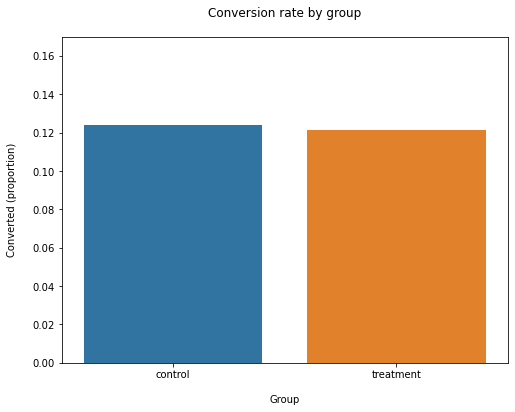

In [48]:
plt.figure(figsize=(8,6))

sns.barplot(x=abt_data['group'], y=abt_data['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### 5. Running the test

In [49]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = abt_data[abt_data['group'] == 'control']['converted']
treatment_results = abt_data[abt_data['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.41
p-value: 0.683
ci 95% for control group: [0.115, 0.133]
ci 95% for treatment group: [0.112, 0.130]


### 6. Decision and summary

### Since our p-value=0.732 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one

Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], or 11.6-13.5%) we notice that:
It includes our baseline value of 13% conversion rate
It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!